In [1]:
#import required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
from skimage.feature import match_template
import numpy as np
from PIL import Image

In [2]:
#open point shapefile
pointData = gpd.read_file('Shp/Training_points.shp')
print('CRS of Point Data: ' + str(pointData.crs))

#open raster file
Pumpking_field = rasterio.open('Rst/pumpkins_field_image.tif')
print('CRS of Raster Data: ' + str(Pumpking_field.crs))
print('Number of Raster Bands: ' + str(Pumpking_field.count))
print('Interpretation of Raster Bands: ' + str(Pumpking_field.colorinterp))

CRS of Point Data: {'init': 'epsg:4326'}
CRS of Raster Data: EPSG:4326
Number of Raster Bands: 3
Interpretation of Raster Bands: (<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


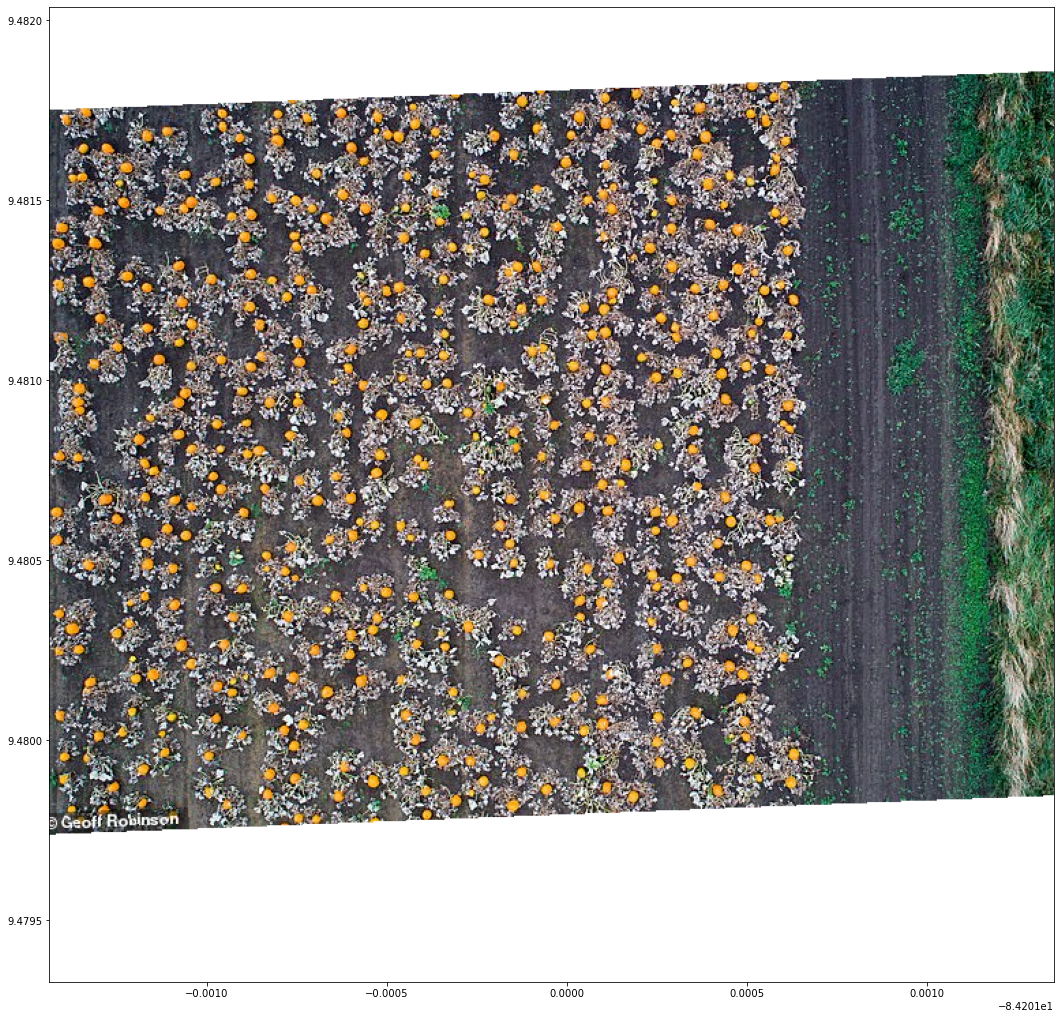

<AxesSubplot:>

In [105]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(18,18))
#pointData.plot(ax=ax, color='orangered', markersize=100)
show(Pumpking_field.read(), transform=src.transform)

In [34]:
#selected band: blue
blueBand = Pumpking_field.read(1)

In [35]:
#extract point value from raster
surveyRowCol = []
for index, values in pointData.iterrows():
    x = values['geometry'].xy[0][0]
    y = values['geometry'].xy[1][0]
    row, col = Pumpking_field.index(x,y)
    print("Point N°:%d corresponds to row, col: %d, %d"%(index,row,col))
    surveyRowCol.append([row,col])

Point N°:0 corresponds to row, col: 125, 24
Point N°:1 corresponds to row, col: 157, 286
Point N°:2 corresponds to row, col: 204, 537
Point N°:3 corresponds to row, col: 190, 358
Point N°:4 corresponds to row, col: 443, 204
Point N°:5 corresponds to row, col: 562, 390
Point N°:6 corresponds to row, col: 551, 27
Point N°:7 corresponds to row, col: 324, 342
Point N°:8 corresponds to row, col: 290, 21
Point N°:9 corresponds to row, col: 299, 244
Point N°:10 corresponds to row, col: 420, 520
Point N°:11 corresponds to row, col: 128, 443
Point N°:12 corresponds to row, col: 291, 161
Point N°:13 corresponds to row, col: 580, 211


In [70]:
# number of template images
print('Number of template images: %d'%len(surveyRowCol))
# define ratio of analysis
radio = 6

Number of template images: 14


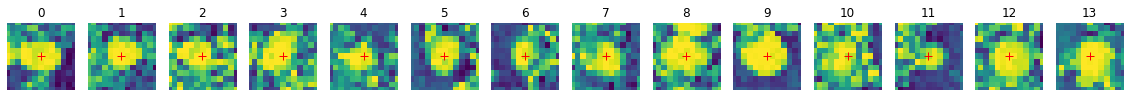

In [102]:
#show all the points of interest, please be careful to have a complete image, otherwise the model wont run
fig, ax = plt.subplots(1, len(surveyRowCol),figsize=(20,5))

for index, item in enumerate(surveyRowCol):
    row = item[0]
    col = item[1]
    ax[index].imshow(blueBand)
    ax[index].plot(col,row,color='red', linestyle='dashed', marker='+',
     markerfacecolor='blue', markersize=8)
    ax[index].set_xlim(col-radio,col+radio)
    ax[index].set_ylim(row-radio,row+radio)
    ax[index].axis('off')
    ax[index].set_title(index)


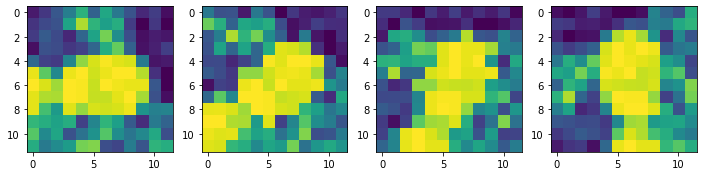

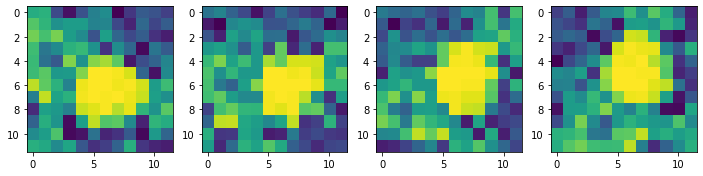

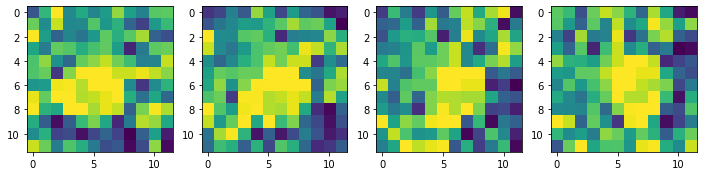

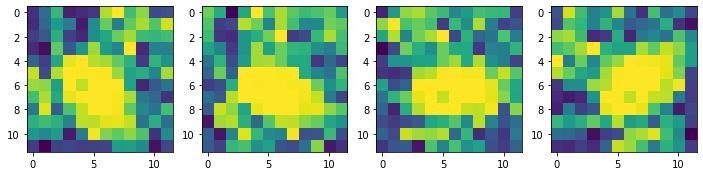

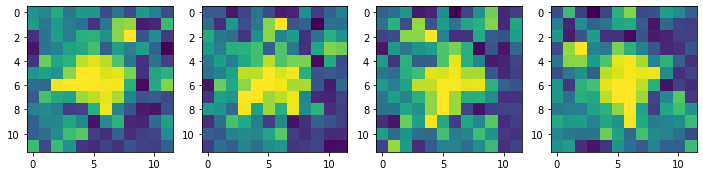

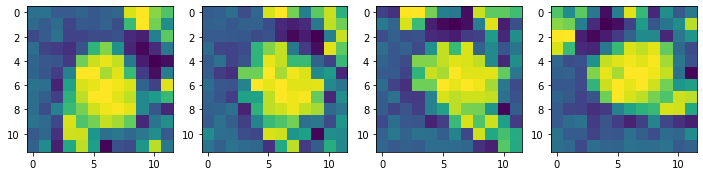

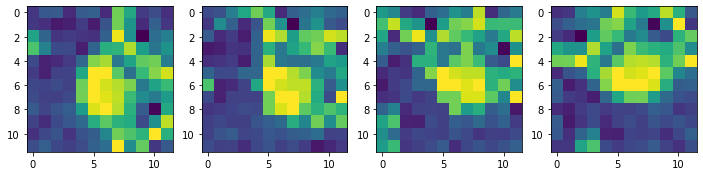

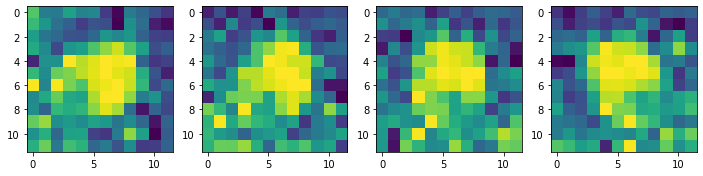

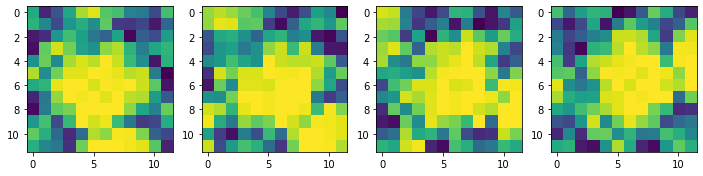

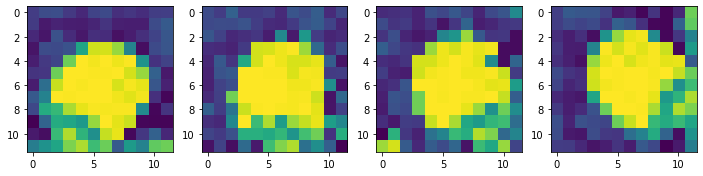

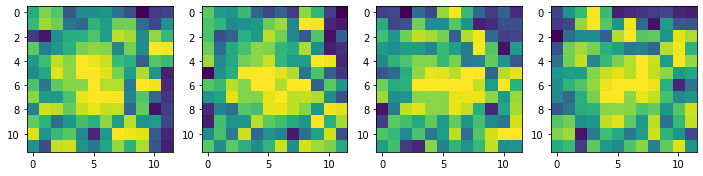

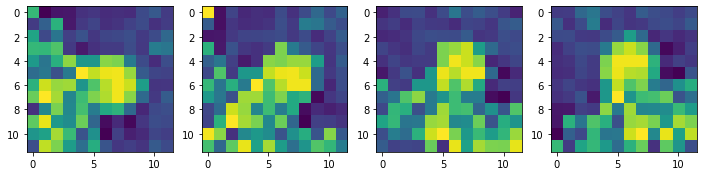

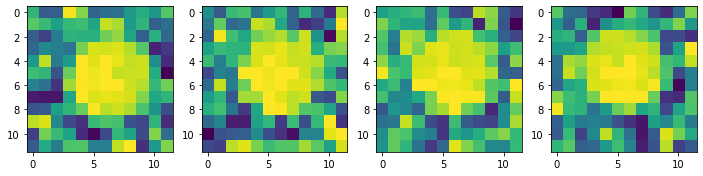

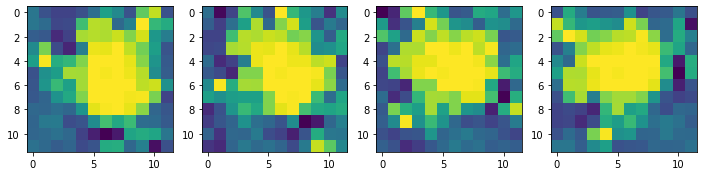

In [72]:
# Match the image to the template

listaresultados = []

templateBandList = []
for rowCol in surveyRowCol:
    imageList = []
    row = rowCol[0]
    col = rowCol[1]
    #append original band
    imageList.append(blueBand[row-radio:row+radio, col-radio:col+radio])
    #append rotated images
    templateBandToRotate = blueBand[row-2*radio:row+2*radio, col-2*radio:col+2*radio]
    rotationList = [i*30 for i in range(1,4)]
    for rotation in rotationList:
        rotatedRaw = Image.fromarray(templateBandToRotate)
        rotatedImage = rotatedRaw.rotate(rotation)
        imageList.append(np.asarray(rotatedImage)[radio:-radio,radio:-radio])
    #plot original and rotated images
    fig, ax = plt.subplots(1, len(imageList),figsize=(12,12))
    for index, item in enumerate(imageList):
        ax[index].imshow(imageList[index])
    #add images to total list
    templateBandList+=imageList

In [77]:
# match the template image to the orthophoto
matchXYList = []
for index, templateband in enumerate(templateBandList):
    if index%10 == 0:
        print('Match template ongoing for figure Nº %d'%index)
    matchTemplate = match_template(blueBand, templateband, pad_input=True)
    matchTemplateFiltered = np.where(matchTemplate>np.quantile(matchTemplate,0.9997))
    for item in zip(matchTemplateFiltered[0],matchTemplateFiltered[1]):
        x, y = Pumpking_field.xy(item[0], item[1])
        matchXYList.append([x,y])

Match template ongoing for figure Nº 0
Match template ongoing for figure Nº 10
Match template ongoing for figure Nº 20
Match template ongoing for figure Nº 30
Match template ongoing for figure Nº 40
Match template ongoing for figure Nº 50


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


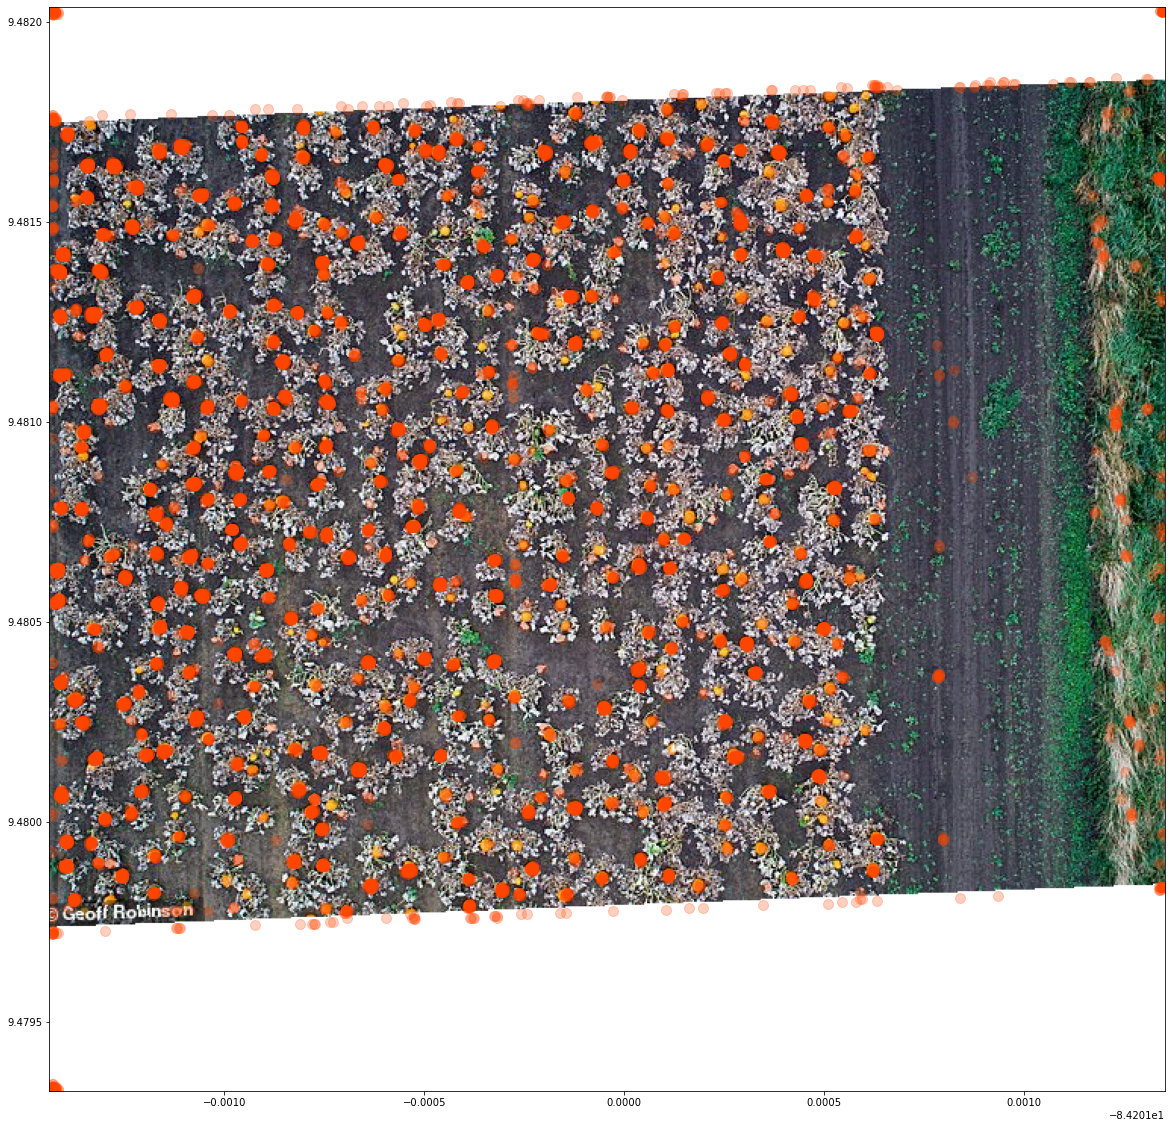

<AxesSubplot:>

In [103]:
# plot interpreted points over the image
fig, ax = plt.subplots(figsize=(20, 20))
matchXYArray = np.array(matchXYList)
ax.scatter(matchXYArray[:,0],matchXYArray[:,1], marker='o',c='orangered', s=100, alpha=0.25)
show(Pumpking_field.read(), transform=src.transform)

In [79]:
# cluster analysis
from sklearn.cluster import Birch
brc = Birch(branching_factor=10000, n_clusters=None, threshold=2e-5, compute_labels=True)
brc.fit(matchXYArray)
birchPoint = brc.subcluster_centers_
birchPoint

array([[-84.19965649,   9.48202766],
       [-84.20180252,   9.4817374 ],
       [-84.20108103,   9.48169892],
       ...,
       [-84.20090245,   9.48139641],
       [-84.2006564 ,   9.48049596],
       [-84.2012242 ,   9.4813321 ]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


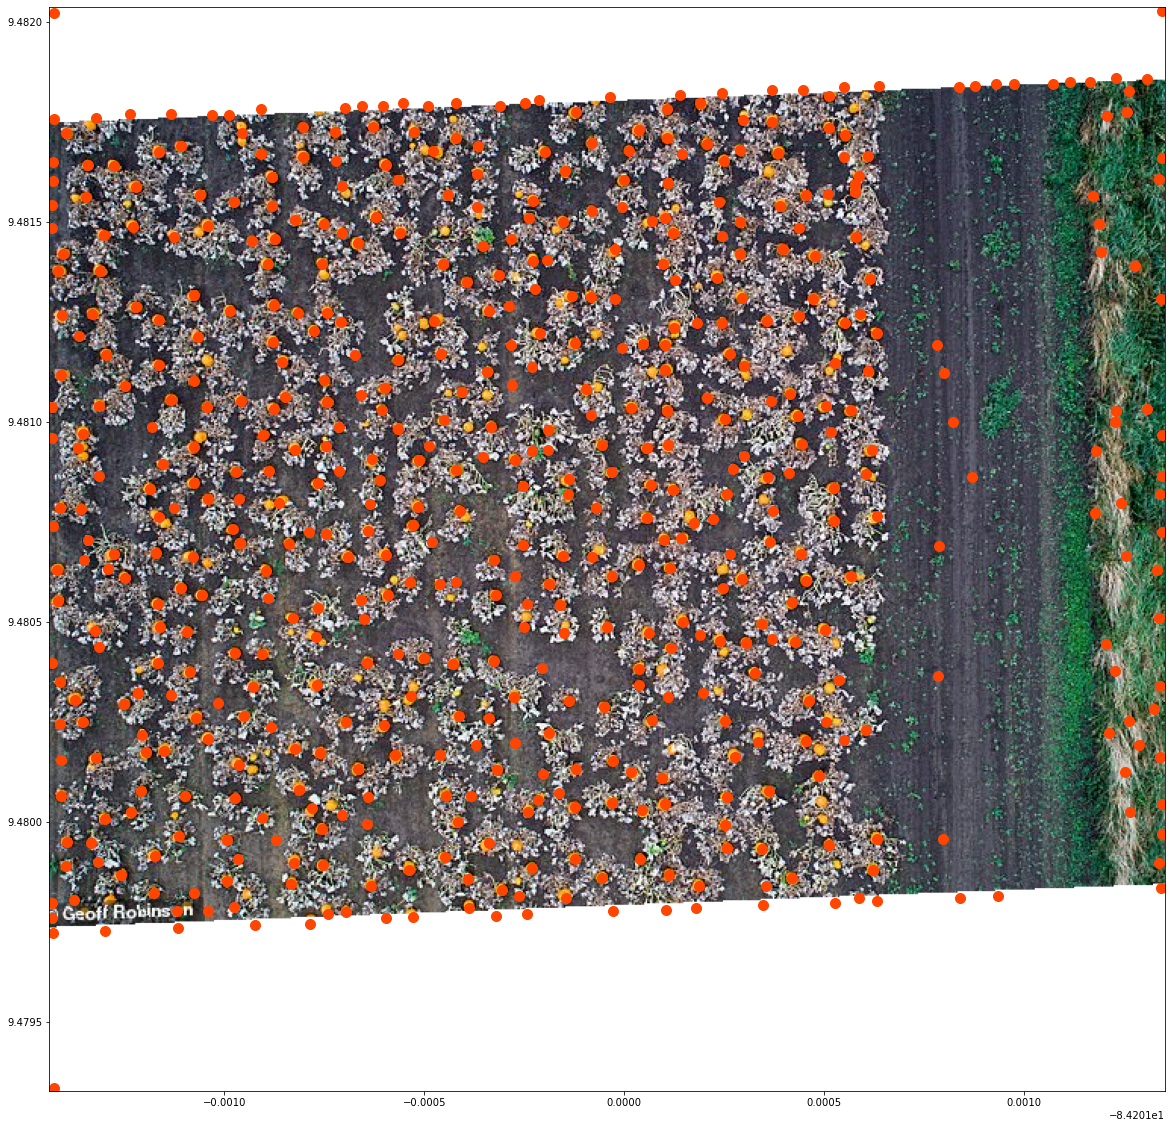

In [104]:
# plot clustered points
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.scatter(birchPoint[:,[0]],birchPoint[:,[1]], marker='o',color='orangered',s=100)
show(Pumpking_field.read(), transform=src.transform)
plt.show()

In [106]:
# save xy to a csv file
np.savetxt("Txt/birchPoints.csv", birchPoint, delimiter=",")